In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import os
#load training dataset
data = []
for filename in os.listdir("D:/keras_png_slices_data/keras_png_slices_train"):
    image_id = filename[5:]
    data.append(os.path.join("D:/keras_png_slices_data/keras_png_slices_train", filename))

data_file_names = []
for filename in data:
    image_id = filename[52:]
    seg = os.path.join("D:/keras_png_slices_data/keras_png_slices_seg_train", "seg" + image_id)
    data_file_names.append([filename, seg])
    #assert(os.path.exists(seg))

In [3]:
#load validation dataset
data_validate = []
for filename in os.listdir("D:/keras_png_slices_data/keras_png_slices_validate"):
    image_id = filename[5:]
    #print(image_id)
    data_validate.append(os.path.join("D:/keras_png_slices_data/keras_png_slices_validate", filename))

validate_file_names = []
for filename in data_validate:
    image_id = filename[55:]
    seg = os.path.join("D:/keras_png_slices_data/keras_png_slices_seg_validate", "seg" + image_id)
    #print(seg)
    validate_file_names.append([filename, seg])
    #assert(os.path.exists(seg))

In [4]:
#load test dataset
data_test = []
for filename in os.listdir("D:/keras_png_slices_data/keras_png_slices_test"):
    image_id = filename[5:]
    #print(image_id)
    data_test.append(os.path.join("D:/keras_png_slices_data/keras_png_slices_test", filename))

test_file_names = []
for filename in data_test:
    image_id = filename[51:]
    seg = os.path.join("D:/keras_png_slices_data/keras_png_slices_seg_test", "seg" + image_id)
    #print(seg)
    test_file_names.append([filename, seg])
    assert(os.path.exists(seg))

In [5]:
print(len(data_file_names))
print(len(validate_file_names))
print(len(test_file_names))

9664
1120
544


In [6]:
def preprocess_image(img):
    #process image
    img = np.array(img).astype('float32')
    img = img / 255
    img = img[:, :, np.newaxis]
    #print(np.unique(image))
    return img

def preprocess_label(label):    
    #process label
    label = np.array(label)
    label = label/85
    label = label[:, :, np.newaxis]
    n_classes = 4
    label = tf.keras.utils.to_categorical(label, 4)
    
    return label

In [7]:
import random
from PIL import Image
def data_generator(batch_size = 8):
    while True:
        xs = []
        ys = []
        for i in range(batch_size):
            img, label = random.choice(data_file_names)
            img = Image.open(img)
            img = preprocess_image(img)
            #img = np.array(img)
            label = Image.open(label)
            label = preprocess_label(label)
            #label = np.array(label)
            xs.append(img)
            ys.append(label)
        xs = np.array(xs).astype('float32')
        ys = np.array(ys)
        yield xs, ys
data_gen = data_generator()

In [8]:
def validate_generator(batch_size = 8):
    while True:
        xs = []
        ys = []
        count = 0
        for i in range(batch_size):
            if count == len(validate_file_names):
                count = 0
            img, label = validate_file_names[count]
            count += 1
            #img, label = random.choice(validate_file_names)
            img = Image.open(img)
            img = preprocess_image(img)
            #img = np.array(img)
            label = Image.open(label)
            label = preprocess_label(label)
            #label = np.array(label)
            xs.append(img)
            ys.append(label)
        xs = np.array(xs).astype('float32')
        ys = np.array(ys)
        yield xs, ys
validate_gen = validate_generator()

In [9]:
def test_generator(batch_size = 1):
    while True:
        xs = []
        ys = []
        count = 0
        for i in range(batch_size):
            img, label = test_file_names[count]
            count += 1
            #img, label = random.choice(validate_file_names)
            img = Image.open(img)
            img = preprocess_image(img)
            #img = np.array(img)
            label = Image.open(label)
            label = preprocess_label(label)
            #label = np.array(label)
            xs.append(img)
            ys.append(label)
        xs = np.array(xs).astype('float32')
        ys = np.array(ys)
        yield xs, ys
test_gen = test_generator()

In [10]:
img, label = next(data_gen)
print(img.shape, label.shape)

(8, 256, 256, 1) (8, 256, 256, 4)


In [11]:
img, label = next(validate_gen)
print(img.shape, label.shape)
img, label = next(test_gen)
print(img.shape, label.shape)

(8, 256, 256, 1) (8, 256, 256, 4)
(1, 256, 256, 1) (1, 256, 256, 4)


In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout,concatenate, UpSampling2D

In [13]:
inputs = Input((256,256,1))
conv1 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(inputs)
conv1 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(pool3)
conv4 = Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(filters = 1024, kernel_size = (3,3), activation = 'relu', padding = 'same')(pool4)
conv5 = Conv2D(filters = 1024, kernel_size = (3,3), activation = 'relu', padding = 'same')(conv5)

up6 = UpSampling2D(size = (2,2))(conv5)
up6 = Conv2D(filters = 512, kernel_size = (2,2), activation = 'relu', padding = 'same')(up6)
up6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(filters = 512, kernel_size = (3,3), activation='relu', padding='same')(up6)
conv6 = Conv2D(filters = 512, kernel_size = (3,3), activation='relu', padding='same')(conv6)

up7 = UpSampling2D(size = (2,2))(conv6)
up7 = Conv2D(filters = 256, kernel_size = (2,2), activation = 'relu', padding = 'same')(up7)
up7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(filters = 256, kernel_size = (3,3), activation='relu', padding='same')(up7)
conv7 = Conv2D(filters = 256, kernel_size = (3,3), activation='relu', padding='same')(conv7)

up8 = UpSampling2D(size = (2,2))(conv7)
up8 = Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu', padding = 'same')(up8)
up8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(filters = 128, kernel_size = (3,3), activation='relu', padding='same')(up8)
conv8 = Conv2D(filters = 128, kernel_size = (3,3), activation='relu', padding='same')(conv8)

up9 = UpSampling2D(size = (2,2))(conv8)
up9 = Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu', padding = 'same')(up9)
up9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(filters = 64, kernel_size = (3,3), activation='relu', padding='same')(up9)
output = Conv2D(4, 1, activation = 'softmax')(conv9)
model = tf.keras.models.Model(inputs, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [15]:
steps_per_epoch = len(data_file_names)/8
valiation_steps = len(validate_file_names)/8
print(steps_per_epoch)
print(valiation_steps)

1208.0
140.0


In [16]:
history = model.fit(data_gen, epochs = 5, validation_data = validate_gen, batch_size = 8, 
                    validation_steps = valiation_steps, validation_batch_size = 8, steps_per_epoch = steps_per_epoch)

Epoch 1/5
1208/1208 [==============================] - 373s 299ms/step - loss: 0.1107 - accuracy: 0.9591 - val_loss: 0.0409 - val_accuracy: 0.9834
Epoch 2/5
1208/1208 [==============================] - 362s 299ms/step - loss: 0.0351 - accuracy: 0.9855 - val_loss: 0.0335 - val_accuracy: 0.9865
Epoch 3/5
1208/1208 [==============================] - 362s 300ms/step - loss: 0.0301 - accuracy: 0.9875 - val_loss: 0.0301 - val_accuracy: 0.9878
Epoch 4/5
1208/1208 [==============================] - 362s 299ms/step - loss: 0.0270 - accuracy: 0.9886 - val_loss: 0.0405 - val_accuracy: 0.9825
Epoch 5/5
1208/1208 [==============================] - 362s 300ms/step - loss: 0.0250 - accuracy: 0.9894 - val_loss: 0.0272 - val_accuracy: 0.9884


In [17]:
model.evaluate(test_gen, batch_size = 1, steps = 544)

544/544 [==============================] - 10s 17ms/step - loss: 0.0323 - accuracy: 0.9862


[0.03232870623469353, 0.9862060546875]

In [18]:
model.evaluate(test_gen, batch_size = 32, steps = 17)

17/17 [==============================] - 0s 17ms/step - loss: 0.0323 - accuracy: 0.9862


[0.03232869878411293, 0.9862060546875]

In [19]:
model.save("models/unet-2.h")

INFO:tensorflow:Assets written to: models/unet-2.h\assets


In [7]:
loaded_model = tf.keras.models.load_model("models/unet-2.h")

In [8]:
def convert_label(y_pred):
    img = np.zeros([256, 256])
    y_pred = y_pred[0]
    for row in range(256):
        for col in range(256):
            label = np.argmax(y_pred[row][col])
            img[row][col] = label
    img = img * 85
    return img

In [9]:
def dsc(y_pred, y_true):
    intersections = 0
    pixels = 256*256 + 256*256
    for row in range(256):
        for col in range(256):
            #print(row,col)
            if y_pred[row][col] ==  y_true[row][col]:
                intersections += 1
    return (2*intersections)/pixels

In [11]:
def dsc_updated(y_pred, y_true):
    y_pred = y_pred/85
    y_true = y_true/85
    intersections = np.array([0, 0, 0, 0])
    y_pred_label_count = np.array([0, 0, 0, 0])
    y_true_label_count = np.array([0, 0, 0, 0])

    pixels = 256*256 + 256*256
    for row in range(256):
        for col in range(256):
            pred_label = int(y_pred[row][col])
            true_label = int(y_true[row][col])
            #print(pred_label)
            y_pred_label_count[pred_label] += 1
            y_true_label_count[true_label] += 1
            if pred_label ==  true_label:
                intersections[pred_label] += 1
    #print(intersections)
    #print(y_pred_label_count)
    #print(y_true_label_count)
    #print(np.sum(y_pred_label_count))
    #print(np.sum(y_true_label_count))
    return 2*intersections/np.add(y_pred_label_count,y_true_label_count)

In [12]:
from PIL import Image
dice_coef = np.array([0, 0, 0, 0]).astype('float64')
count = 0
#a = [test_file_names[0]]
for img, label in test_file_names:
#for img, label in a:
    img = Image.open(img)
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0) 
    y_pred = loaded_model.predict(img, batch_size = 1) #make batch size = 1
    y_pred = convert_label(y_pred)
    #print(y_pred.shape)

    y_true = Image.open(label)
    y_true = np.array(y_true)
    #print(y_true.shape)
    dice_coef = np.add(dice_coef, dsc_updated(y_pred, y_true))
    count += 1
    print(count)
dice_coef/len(test_file_names)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


array([0.99919426, 0.94835217, 0.95838415, 0.9747188 ])

In [14]:
from PIL import Image
dice_coef = 0
count = 0
for img, label in test_file_names:
    img = Image.open(img)
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0) 
    y_pred = loaded_model.predict(img, batch_size = 1) #make batch size = 1
    y_pred = convert_label(y_pred)
    #print(y_pred.shape)

    y_true = Image.open(label)
    y_true = np.array(y_true)
    #print(y_true.shape)
    dice_coef += dsc(y_pred, y_true)
    count += 1
    print(count)
dice_coef/len(test_file_names)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


0.9896035755381865

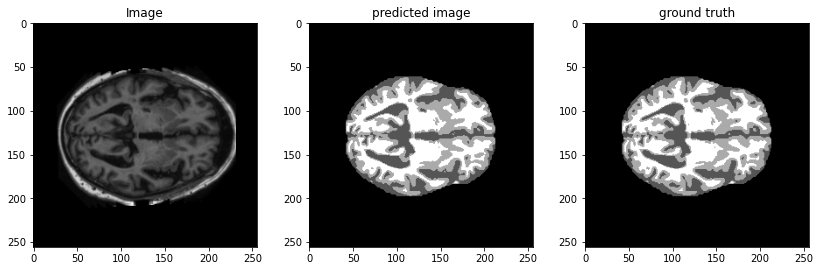

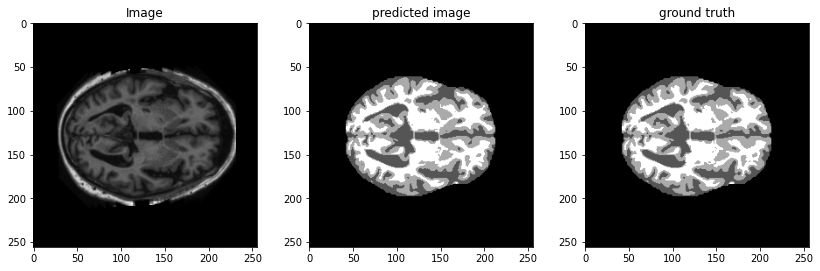

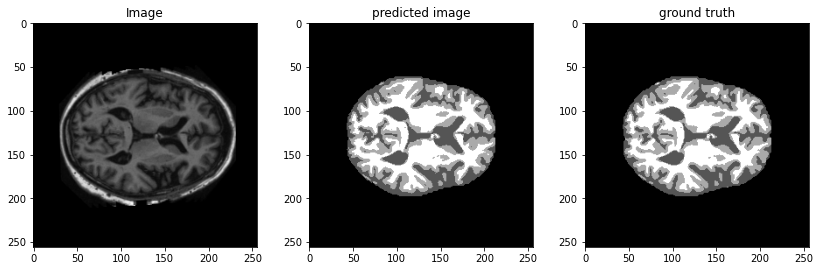

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
index = 1

for i in range(3):
    #print(test_file_names[i])
    #plot image
    img = Image.open(test_file_names[i][0])
    plt.figure(figsize = (14,14))
    plt.subplot(3,3,3*i+1);
    plt.imshow(img, cmap = 'gray')
    plt.gca().set_title('Image')
    
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0) 
    index += 1
    
    #plot prediction image
    y_pred = loaded_model.predict(img, batch_size = 1)#make batch size = 1
    y_pred = convert_label(y_pred)
    
    plt.subplot(3,3,3*i+2);
    plt.imshow(y_pred, cmap = 'gray')
    #plt.figure(figsize = (10,12))
    plt.gca().set_title('predicted image')
    index += 1
    
    #plot ground truth
    y_true = Image.open(test_file_names[i][1])
    
    #plt.figure(figsize = (10,12))
    plt.subplot(3,3,3*i +3);
    plt.imshow(y_true, cmap = 'gray')
    plt.gca().set_title('ground truth')
    index += 1